In [1]:
import sys
import json
import pandas as pd
import matplotlib.pyplot as plt
from sage_data_client import query
import numpy as np

In [13]:
def get_measurements(vsn, name):
    return query(
    start="-1h",
    filter={
        "name": name,
        "vsn": vsn.upper(),
        }
    )

def get_events(vsn):
    return query(
    start="-90d",
    filter={
        "name": "sys.scheduler.status.plugin.*",
        "vsn": vsn.upper(),
        }
    )

def parse_events(df):
    v = []
    for _, row in df.iterrows():
        r = json.loads(row.value)
        r["timestamp"] = row.timestamp.isoformat()
        r["node"] = row["meta.node"]
        r["vsn"] = row["meta.vsn"]
        r["event"] = row["name"]
        v.append(r)
    return pd.read_json(json.dumps(v))

def get_plugins(df):
    return df.plugin_name.unique()

def fill_completion_failure(df):
    # Filter only events related to plugin execution
    launched = df[df.event.str.contains("launched")]
    completed = df[df.event.str.contains("complete")]
    failed = df[df.event.str.contains("failed")]
    for index, p in launched.iterrows():
        found = completed[completed.k3s_pod_name == p.k3s_pod_name]
        if len(found) > 0:
            launched.loc[index, "completed_at"] = found.iloc[0].timestamp
            launched.loc[index, "end_state"] = "completed"
        else:
            found = failed[failed.k3s_pod_name == p.k3s_pod_name]
            if len(found) > 0:
                launched.loc[index, "failed_at"] = found.iloc[0].timestamp
                launched.loc[index, "reason"] = found.iloc[0].reason
                launched.loc[index, "end_state"] = "failed"
            else:
                launched.loc[index, "end_state"] = "unknown"
    return launched

def get_statistics(df):
    stats = {}
    for name, df in plugins:
        df.iloc[0].vsn
        n_completed = len(df[df.completed_at.notnull() == True])
        n_failed = len(df[df.failed_at.notnull() == True])
        n_unknown = len(df[(df.completed_at.isnull()) & (df.failed_at.isnull())])
        stats[name] = pd.Series(name=name, data=[n_completed, n_failed, n_unknown, df.iloc[0].vsn], index=["completed", "failed", "unknown", "vsn"])
    out = pd.DataFrame(stats)
    return out


In [16]:
w022 = get_measurements("w022", name="upload")

In [17]:
w022

,timestamp,name,value,meta.filename,meta.host,meta.job,meta.node,meta.plugin,meta.task,meta.vsn
0,2022-08-31 22:23:43.305618574+00:00,upload,https://storage.sagecontinuum.org/api/v1/data/...,panda-cam-stream_2022-08-31-22-01-53_0.bag,000048b02d15bda5.ws-nxcore,Pluginctl,000048b02d15bda5,lblanp/panda-plugin-rosbag:v1.0.1,wes-panda-cam-rosbag,W022
1,2022-08-31 22:46:05.330074165+00:00,upload,https://storage.sagecontinuum.org/api/v1/data/...,panda-cam-stream_2022-08-31-22-23-41_1.bag,000048b02d15bda5.ws-nxcore,Pluginctl,000048b02d15bda5,lblanp/panda-plugin-rosbag:v1.0.1,wes-panda-cam-rosbag,W022
2,2022-08-31 23:08:57.426466638+00:00,upload,https://storage.sagecontinuum.org/api/v1/data/...,panda-cam-stream_2022-08-31-22-46-05_2.bag,000048b02d15bda5.ws-nxcore,Pluginctl,000048b02d15bda5,lblanp/panda-plugin-rosbag:v1.0.1,wes-panda-cam-rosbag,W022
3,2022-08-31 23:32:29.497372226+00:00,upload,https://storage.sagecontinuum.org/api/v1/data/...,panda-cam-stream_2022-08-31-23-08-56_3.bag,000048b02d15bda5.ws-nxcore,Pluginctl,000048b02d15bda5,lblanp/panda-plugin-rosbag:v1.0.1,wes-panda-cam-rosbag,W022
4,2022-08-31 23:56:32.098024199+00:00,upload,https://storage.sagecontinuum.org/api/v1/data/...,panda-cam-stream_2022-08-31-23-32-20_4.bag,000048b02d15bda5.ws-nxcore,Pluginctl,000048b02d15bda5,lblanp/panda-plugin-rosbag:v1.0.1,wes-panda-cam-rosbag,W022
...,...,...,...,...,...,...,...,...,...,...
16860,2022-08-12 14:20:06.570317440+00:00,upload,https://storage.sagecontinuum.org/api/v1/data/...,sample.mp4,0000dca63288fab0.ws-rpi,video-sampler-bottom-1660313700,000048b02d15bda5,video-sampler:0.2.4,video-sampler-bottom,W022
16861,2022-08-12 14:25:06.730480985+00:00,upload,https://storage.sagecontinuum.org/api/v1/data/...,sample.mp4,0000dca63288fab0.ws-rpi,video-sampler-bottom-1660314000,000048b02d15bda5,video-sampler:0.2.4,video-sampler-bottom,W022
16862,2022-08-12 14:30:06.546047883+00:00,upload,https://storage.sagecontinuum.org/api/v1/data/...,sample.mp4,0000dca63288fab0.ws-rpi,video-sampler-bottom-1660314300,000048b02d15bda5,video-sampler:0.2.4,video-sampler-bottom,W022
16863,2022-08-12 14:35:15.692164038+00:00,upload,https://storage.sagecontinuum.org/api/v1/data/...,sample.mp4,0000dca63288fab0.ws-rpi,video-sampler-bottom-1660314600,000048b02d15bda5,video-sampler:0.2.4,video-sampler-bottom,W022


In [6]:
v001 = fill_completion_failure(parse_events(get_events("v001")))

/var/folders/tr/7n6yv5q54t73qs20cl85h5xm0000gn/T/ipykernel_52727/2456778803.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  launched.loc[index, "end_state"] = "unknown"
/var/folders/tr/7n6yv5q54t73qs20cl85h5xm0000gn/T/ipykernel_52727/2456778803.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  launched.loc[index, "completed_at"] = found.iloc[0].timestamp
/var/folders/tr/7n6yv5q54t73qs20cl85h5xm0000gn/T/ipykernel_52727/2456778803.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [18]:
v = w022[w022["meta.task"].str.contains("video-sampler-bottom")]

In [21]:
for _, a in v.iterrows():
    print(a.value)

https://storage.sagecontinuum.org/api/v1/data/video-sampler-bottom-1660143300/sage-video-sampler-bottom-0.2.4/000048b02d15bda5/1660161606568584297-sample.mp4
https://storage.sagecontinuum.org/api/v1/data/video-sampler-bottom-1660161600/sage-video-sampler-bottom-0.2.4/000048b02d15bda5/1660161907070010156-sample.mp4
https://storage.sagecontinuum.org/api/v1/data/video-sampler-bottom-1660161900/sage-video-sampler-bottom-0.2.4/000048b02d15bda5/1660162206720101896-sample.mp4
https://storage.sagecontinuum.org/api/v1/data/video-sampler-bottom-1660162200/sage-video-sampler-bottom-0.2.4/000048b02d15bda5/1660162506419687915-sample.mp4
https://storage.sagecontinuum.org/api/v1/data/video-sampler-bottom-1660162500/sage-video-sampler-bottom-0.2.4/000048b02d15bda5/1660162806622058510-sample.mp4
https://storage.sagecontinuum.org/api/v1/data/video-sampler-bottom-1660162800/sage-video-sampler-bottom-0.2.4/000048b02d15bda5/1660163116976457146-sample.mp4
https://storage.sagecontinuum.org/api/v1/data/video-

In [7]:
v001

,goal_id,k3s_job_name,k3s_job_status,k3s_pod_name,k3s_pod_node_name,k3s_pod_status,plugin_args,plugin_image,plugin_name,plugin_selector,plugin_status_by_scheduler,plugin_task,timestamp,node,vsn,event,reason,end_state,completed_at,failed_at
1263,de67d2be-7ea3-4f75-6c95-96592b2302e6,object-counter-neon40,NaN,NaN,NaN,NaN,-stream http://10.123.32.40/nph-mjpeg.cgi -all...,registry.sagecontinuum.org/seonghapark/object-...,object-counter-neon40,"{""resource.gpu"":""true""}",Running,object-counter-neon40,2022-11-06 21:30:05.832748537+00:00,00004cd98fc4d2a8,V001,sys.scheduler.status.plugin.launched,NaN,unknown,NaT,NaN
1264,de67d2be-7ea3-4f75-6c95-96592b2302e6,object-counter-neon41,NaN,object-counter-neon41-z2x2g,00004cd98fc4d2a8.sb-core,Pending,-stream http://10.123.32.41/nph-mjpeg.cgi -all...,registry.sagecontinuum.org/seonghapark/object-...,object-counter-neon41,"{""resource.gpu"":""true""}",Running,object-counter-neon41,2022-11-06 21:30:21.377094354+00:00,00004cd98fc4d2a8,V001,sys.scheduler.status.plugin.launched,NaN,completed,2022-11-06 21:30:35.416650256+00:00,NaN
1265,de67d2be-7ea3-4f75-6c95-96592b2302e6,smoke-detector-neon41,NaN,smoke-detector-neon41-sqnkm,,Pending,http://10.123.32.41/nph-mjpeg.cgi,registry.sagecontinuum.org/iperezx/wildfire-sm...,smoke-detector-neon41,"{""resource.gpu"":""true""}",Running,smoke-detector-neon41,2022-11-06 21:30:35.452585880+00:00,00004cd98fc4d2a8,V001,sys.scheduler.status.plugin.launched,NaN,completed,2022-11-06 21:30:48.452686891+00:00,NaN
1266,de67d2be-7ea3-4f75-6c95-96592b2302e6,cloud-cover-neon41,NaN,cloud-cover-neon41-fsvjk,,Pending,-stream http://10.123.32.41/nph-mjpeg.cgi,registry.sagecontinuum.org/seonghapark/cloud-c...,cloud-cover-neon41,"{""resource.gpu"":""true""}",Running,cloud-cover-neon41,2022-11-06 21:30:48.492702881+00:00,00004cd98fc4d2a8,V001,sys.scheduler.status.plugin.launched,NaN,completed,2022-11-06 21:31:14.584024985+00:00,NaN
1267,de67d2be-7ea3-4f75-6c95-96592b2302e6,object-counter-neon40,NaN,NaN,NaN,NaN,-stream http://10.123.32.40/nph-mjpeg.cgi -all...,registry.sagecontinuum.org/seonghapark/object-...,object-counter-neon40,"{""resource.gpu"":""true""}",Running,object-counter-neon40,2022-11-06 21:35:05.021938548+00:00,00004cd98fc4d2a8,V001,sys.scheduler.status.plugin.launched,NaN,unknown,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2521,e16d430c-d7e5-4d56-5b36-67fd18f4e829,object-counter-neon41,NaN,object-counter-neon41-c4cpk,00004cd98fc4d2a8.sb-core,Pending,-stream http://10.123.32.41/nph-mjpeg.cgi -all...,registry.sagecontinuum.org/yonghokim/object-co...,object-counter-neon41,"{""resource.gpu"":""true""}",Running,object-counter-neon41,2022-11-07 21:25:29.783208201+00:00,00004cd98fc4d2a8,V001,sys.scheduler.status.plugin.launched,BackoffLimitExceeded,failed,NaN,2022-11-07 21:25:34.660683480+00:00
2522,e16d430c-d7e5-4d56-5b36-67fd18f4e829,object-counter-neon40,NaN,object-counter-neon40-z8h8f,00004cd98fc4d2a8.sb-core,Pending,-stream http://10.123.32.40/nph-mjpeg.cgi -all...,registry.sagecontinuum.org/yonghokim/object-co...,object-counter-neon40,"{""resource.gpu"":""true""}",Running,object-counter-neon40,2022-11-07 21:25:34.700839904+00:00,00004cd98fc4d2a8,V001,sys.scheduler.status.plugin.launched,BackoffLimitExceeded,failed,NaN,2022-11-07 21:25:39.661082652+00:00
2523,e16d430c-d7e5-4d56-5b36-67fd18f4e829,object-counter-neon40,NaN,object-counter-neon40-6lrw4,00004cd98fc4d2a8.sb-core,Pending,-stream http://10.123.32.40/nph-mjpeg.cgi -all...,registry.sagecontinuum.org/yonghokim/object-co...,object-counter-neon40,"{""resource.gpu"":""true""}",Running,object-counter-neon40,2022-11-07 21:25:44.385231258+00:00,00004cd98fc4d2a8,V001,sys.scheduler.status.plugin.launched,BackoffLimitExceeded,failed,NaN,2022-11-07 21:25:49.730994312+00:00
2524,e16d430c-d7e5-4d56-5b36-67fd18f4e829,object-counter-neon41,NaN,object-counter-neon41-s8bpd,00004cd98fc4d2a8.sb-core,Pending,-stream http://10.123.32.41/nph-mjpeg.cgi -all...,registry.sagecontinuum.or

In [259]:
w024 = fill_completion_failure(parse_events(get_events("w024")))
w026 = fill_completion_failure(parse_events(get_events("w026")))

/var/folders/tr/7n6yv5q54t73qs20cl85h5xm0000gn/T/ipykernel_10304/275536378.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  launched.loc[index, "end_state"] = "unknown"
/var/folders/tr/7n6yv5q54t73qs20cl85h5xm0000gn/T/ipykernel_10304/275536378.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  launched.loc[index, "completed_at"] = found.iloc[0].timestamp
/var/folders/tr/7n6yv5q54t73qs20cl85h5xm0000gn/T/ipykernel_10304/275536378.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [260]:
df = w024.append(w026)

/var/folders/tr/7n6yv5q54t73qs20cl85h5xm0000gn/T/ipykernel_10304/1033659570.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = w024.append(w026)


In [261]:
df

,goal_id,k3s_job_name,k3s_job_status,k3s_pod_name,k3s_pod_node_name,k3s_pod_status,plugin_args,plugin_image,plugin_name,plugin_selector,plugin_task,timestamp,node,vsn,event,reason,end_state,completed_at,failed_at,plugin_status_by_scheduler
608,6eccb406-0f5d-4977-5e05-b8e105a57dc6,cloud-cover-top,NaN,NaN,NaN,NaN,-stream top,registry.sagecontinuum.org/seonghapark/cloud-c...,cloud-cover-top,"{""resource.gpu"":""true""}",cloud-cover-top,2022-11-03 20:40:33.872722197+00:00,000048b02d15bc73,W024,sys.scheduler.status.plugin.launched,NaN,unknown,NaT,NaN,NaN
609,6eccb406-0f5d-4977-5e05-b8e105a57dc6,sound-event-detection,NaN,NaN,NaN,NaN,--DURATION_S 5 --PUBLISH,registry.sagecontinuum.org/dariodematties/soun...,sound-event-detection,null,sound-event-detection,2022-11-03 20:40:33.909104771+00:00,000048b02d15bc73,W024,sys.scheduler.status.plugin.launched,NaN,unknown,NaT,NaN,NaN
610,4a0dff2f-010e-4b1a-7b26-23f3f6056159,surfacewater-classifier,NaN,surfacewater-classifier-z5tds,000048b02d15bc73.ws-nxcore,Pending,-stream bottom -model /app/model.pth -sampling...,registry.sagecontinuum.org/seonghapark/surface...,surfacewater-classifier,"{""resource.gpu"":""true""}",surfacewater-classifier,2022-11-03 20:45:13.689271762+00:00,000048b02d15bc73,W024,sys.scheduler.status.plugin.launched,NaN,completed,2022-11-03 20:48:58.470103750+00:00,NaN,NaN
611,6eccb406-0f5d-4977-5e05-b8e105a57dc6,object-counter-bottom,NaN,object-counter-bottom-8w6gr,000048b02d15bc73.ws-nxcore,Pending,-stream bottom -all-objects,registry.sagecontinuum.org/yonghokim/object-co...,object-counter-bottom,"{""resource.gpu"":""true""}",object-counter-bottom,2022-11-03 20:45:13.785838626+00:00,000048b02d15bc73,W024,sys.scheduler.status.plugin.launched,NaN,completed,2022-11-03 20:49:08.486329415+00:00,NaN,NaN
612,6eccb406-0f5d-4977-5e05-b8e105a57dc6,cloud-cover-top,NaN,cloud-cover-top-5vddd,000048b02d15bc73.ws-nxcore,Pending,-stream top,registry.sagecontinuum.org/seonghapark/cloud-c...,cloud-cover-top,"{""resource.gpu"":""true""}",cloud-cover-top,2022-11-03 20:50:05.579357842+00:00,000048b02d15bc73,W024,sys.scheduler.status.plugin.launched,NaN,completed,2022-11-03 21:01:24.641095519+00:00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1343,8574933f-3e2f-419e-5776-1b2fcbeaa6fe,cloud-cover-top,NaN,cloud-cover-top-l5gg4,000048b02d05a1c7.ws-nxcore,Pending,-stream top,registry.sagecontinuum.org/seonghapark/cloud-c...,cloud-cover-top,"{""resource.gpu"":""true""}",cloud-cover-top,2022-11-04 20:30:05.520280365+00:00,000048b02d05a1c7,W026,sys.scheduler.status.plugin.launched,NaN,completed,2022-11-04 20:31:22.923215173+00:00,NaT,Running
1344,8574933f-3e2f-419e-5776-1b2fcbeaa6fe,cloud-motion-top,NaN,cloud-motion-top-r7zwz,000048b02d05a1c7.ws-nxcore,Pending,--input top,registry.sagecontinuum.org/bhupendraraut/cloud...,cloud-motion-top,"{""resource.gpu"":""true""}",cloud-motion-top,2022-11-04 20:31:23.132265310+00:00,000048b02d05a1c7,W026,sys.scheduler.status.plugin.launched,NaN,failed,NaT,2022-11-04 20:31:29.992243934+00:00,Running
1345,8574933f-3e2f-419e-5776-1b2fcbeaa6fe,object-counter-bottom,NaN,object-counter-bottom-64fpw,000048b02d05a1c7.ws-nxcore,Pending,-stream bottom -all-objects,registry.sagecontinuum.org/yonghokim/object-co...,object-counter-bottom,"{""resource.gpu"":""true""}",object-counter-bottom,2022-11-04 20:31:30.108171137+00:00,000048b02d05a1c7,W026,sys.scheduler.status.plugin.launched,NaN,completed,2022-11-04 20:32:07.460027798+00:00,NaT,Running
1346,8574933f-3e2f-419e-5776-1b2fcbeaa6fe,sound-event-detection,NaN,sound-event-detection-pt4hf,000048b02d05a1c7.ws-nxcore,Pending,--DURATION_S 5 --PUBLISH,registry.sagecontinuum.org/dariodematties/soun...,sound-event-detection,null,sound-event-detection,2022-11-04 20:32:07.624034950+00:00,000048b02d05a1c7,W026,sys.scheduler.status.plugin.launched,NaN,completed,2022-11-04 20:32:27.523305892+00:00,NaT,Running


In [415]:
grouped = df.groupby(by=["plugin_name", "end_state", "vsn"])

In [384]:
grouped.size().unstack(fill_value=0).unstack(fill_value=0)

end_state         completed                                       \
plugin_name cloud-cover-top cloud-motion-top imagesampler-bottom   
vsn                                                                
W024                     82                0                  18   
W026                    132                0                  25   

end_state                                                                 \
plugin_name imagesampler-top object-counter-bottom sound-event-detection   
vsn                                                                        
W024                      19                   127                    95   
W026                      23                   286                   139   

end_state                                    failed                   \
plugin_name surfacewater-classifier cloud-cover-top cloud-motion-top   
vsn                                                                    
W024                            145               1               63   
W026                              0               4               47   

end_state                        ...                        \
plugin_name imagesampler-bottom  ... object-counter-bottom   
vsn                              ...                         
W024                          0  ...                     1   
W026                          0  ...                     2   

end_state                                                         unknown  \
plugin_name sound-event-detection surfacewater-classifier cloud-cover-top   
vsn                                                                         
W024                            3                       0              11   
W026                            0                       0               7   

end_state                                                          \
plugin_name cloud-motion-top imagesampler-bottom imagesampler-top   
vsn                                                                 
W024                       3                   3                3   
W026                       1                   0                1   

end_state                                                \
plugin_name object-counter-bottom sound-event-detection   
vsn                                                       
W024                           10                    14   
W026                            2                     4   

end_state                            
plugin_name surfacewater-classifier  
vsn                                  
W024                              4  
W026                              0  

[2 rows x 21 columns]

In [394]:
a = grouped.size()

In [396]:
stat_w024 = a.filter(like="W024")
stat_w026 = a.filter(like="W026")

In [401]:
stat_w024.unstack(fill_value=0).reset_index()

end_state,vsn,plugin_name,completed,failed,unknown
0,W024,cloud-cover-top,82,1,11
1,W024,cloud-motion-top,0,63,3
2,W024,imagesampler-bottom,18,0,3
3,W024,imagesampler-top,19,0,3
4,W024,object-counter-bottom,127,1,10
5,W024,sound-event-detection,95,3,14
6,W024,surfacewater-classifier,145,0,4


<AxesSubplot: xlabel='plugin_name'>

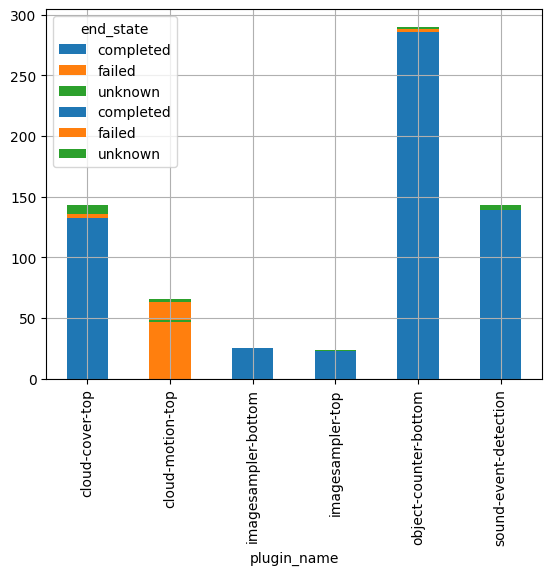

In [412]:
fix, ax = plt.subplots()
stat_w024.unstack(fill_value=0).reset_index().plot(kind='bar', x="plugin_name", grid=True, stacked=True, ax=ax)
stat_w026.unstack(fill_value=0).reset_index().plot(kind='bar', x="plugin_name", grid=True, stacked=True, ax=ax)

<AxesSubplot: xlabel='plugin_name,end_state'>

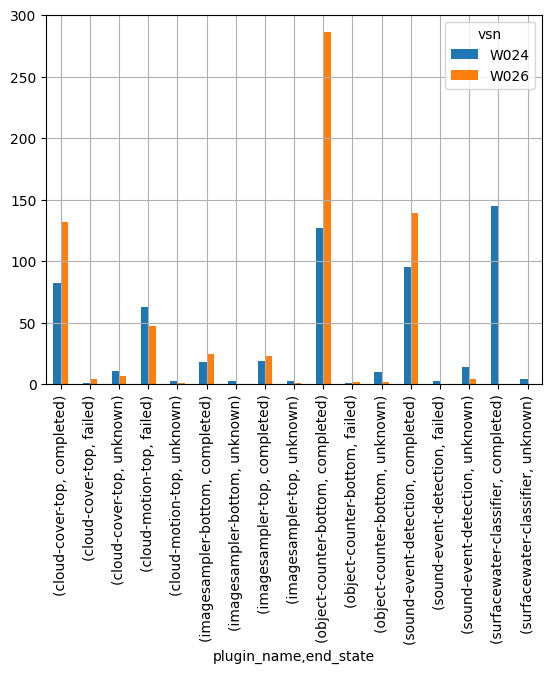

In [420]:
# fix, ax = plt.subplots()
grouped.size().unstack(fill_value=0).plot(kind='bar',grid=True)

In [421]:
grouped.size().unstack(fill_value=0)

vsn                                W024  W026
plugin_name             end_state            
cloud-cover-top         completed    82   132
                        failed        1     4
                        unknown      11     7
cloud-motion-top        failed       63    47
                        unknown       3     1
imagesampler-bottom     completed    18    25
                        unknown       3     0
imagesampler-top        completed    19    23
                        unknown       3     1
object-counter-bottom   completed   127   286
                        failed        1     2
                        unknown      10     2
sound-event-detection   completed    95   139
                        failed        3     0
                        unknown      14     4
surfacewater-classifier completed   145     0
                        unknown       4     0